<a href="https://colab.research.google.com/github/SeanHutcheson/vision/blob/main/Welcome_to_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
from google.colab import files

# Step 1: Upload the Excel file
def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

# Step 2: Process the Excel file
def process_file(file_name):
    # Read the file
    data = pd.read_excel(file_name, header=None)

    # Extract relevant columns starting from row 10 (index 9)
    portfolio_data = data.iloc[9:, [0, 1, 2, 3, 4, 5]]  # Portfolio
    benchmark_data = data.iloc[9:, [0, 6, 7, 8, 9, 10]]  # Benchmark

    # Rename columns for clarity
    portfolio_data.columns = ["Bond_Name", "Currency", "Country", "Sector", "Rating", "Spread"]
    benchmark_data.columns = ["Bond_Name", "Currency", "Country", "Sector", "Rating", "Spread"]

    # Filter portfolio and benchmark rows
    portfolio_data = portfolio_data.dropna(subset=["Currency", "Country", "Sector", "Rating", "Spread"])
    benchmark_data = benchmark_data.dropna(subset=["Currency", "Country", "Sector", "Rating", "Spread"])

    return portfolio_data, benchmark_data

# Step 3: Compare bonds and generate output
def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None):
    result = []

    for _, portfolio_row in portfolio_data.iterrows():
        # Filter benchmark data to match characteristics of the portfolio bond
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"])
        ]

        if not matches.empty:
            # Find the bond in the benchmark with the highest spread
            best_match = matches.loc[matches["Spread"].idxmax()]
            spread_pickup = best_match["Spread"] - portfolio_row["Spread"]

            if max_spread_pickup is None or spread_pickup < max_spread_pickup:
                result.append([
                    portfolio_row["Bond_Name"],
                    portfolio_row["Currency"],
                    portfolio_row["Country"],
                    portfolio_row["Sector"],
                    portfolio_row["Rating"],
                    portfolio_row["Spread"],
                    best_match["Bond_Name"],
                    best_match["Spread"],
                    spread_pickup
                ])

    # Create a DataFrame for results
    result_df = pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Currency", "Country", "Sector", "Rating", "Portfolio_Spread",
        "Benchmark_Bond", "Benchmark_Spread", "Spread_Pickup"
    ])

    # Sort results by Spread Pickup in descending order
    result_df = result_df.sort_values(by="Spread_Pickup", ascending=False)

    return result_df

# Step 4: Main script execution
def main():
    # Upload and process file
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Compare bonds for all spread pickups
    result_df = compare_bonds(portfolio_data, benchmark_data)

    # Compare bonds with spread pickup < 100
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)

    # Save the output to a new Excel file with multiple sheets
    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)

    print(f"Output saved to {output_file}")

    # Allow user to download the output file
    files.download(output_file)

# Run the script
if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving BlueBay IG.xlsx to BlueBay IG (6).xlsx
Uploaded file: BlueBay IG (6).xlsx
Output saved to Vision_Output.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import pandas as pd
from google.colab import files

# Step 1: Upload the Excel file
def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

# Step 2: Process the Excel file
def process_file(file_name):
    # Read the file
    data = pd.read_excel(file_name, header=7)  # Header is row 8 (index 7 in Python)

    # Extract the bond names and relevant columns for portfolio and benchmark
    bond_names = data.iloc[:, 0]  # Column A: Bond Names
    portfolio_data = data.iloc[:, 1:8]  # Portfolio (columns B-H)
    benchmark_data = data.iloc[:, 8:15]  # Benchmark (columns I-O)

    # Rename columns for clarity
    portfolio_data.columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    benchmark_data.columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]

    # Filter rows with missing values
    portfolio_data = portfolio_data.dropna()
    benchmark_data = benchmark_data.dropna()

    # Add bond names back to portfolio_data for identification
    portfolio_data["Bond_Name"] = bond_names

    return portfolio_data, benchmark_data

# Step 3: Compare bonds and generate output
def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None, similar_spread=False, higher_rating=False):
    rating_order = ["AAA+", "AAA", "AAA-", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC+", "CC", "CC-", "C+", "C", "C-", "D", "NR"]
    result = []

    for _, portfolio_row in portfolio_data.iterrows():
        # Skip invalid ratings
        if portfolio_row["Rating"] not in rating_order:
            print(f"Skipping portfolio bond with invalid rating: {portfolio_row['Rating']}")
            continue

        # Filter benchmark data to match characteristics of the portfolio bond
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"])
        ]

        if higher_rating:
            # Filter matches for bonds with a higher rating
            portfolio_rating_index = rating_order.index(portfolio_row["Rating"])
            matches = matches[matches["Rating"].apply(lambda x: x in rating_order and rating_order.index(x) < portfolio_rating_index)]

        if similar_spread:
            # Filter matches for bonds with similar spread (0.9-1.1x the portfolio bond's spread)
            matches = matches[(matches["OAS"] >= 0.9 * portfolio_row["OAS"]) &
                              (matches["OAS"] <= 1.1 * portfolio_row["OAS"])]

        if not matches.empty:
            # Find the bond in the benchmark with the highest spread
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"],
                    portfolio_row["Currency"],
                    portfolio_row["Country"],
                    portfolio_row["Sector"],
                    portfolio_row["Rating"],
                    portfolio_row["OAS"],
                    portfolio_row["OAD"],
                    portfolio_row["Subordination"],
                    best_match["Currency"],
                    best_match["Country"],
                    best_match["Sector"],
                    best_match["Rating"],
                    best_match["OAS"],
                    best_match["OAD"],
                    spread_pickup
                ])

    # Create a DataFrame for results
    result_df = pd.DataFrame(result, columns=[
        "Bond_Name", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_OAS", "Portfolio_OAD", "Portfolio_Subordination",
        "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ])

    # Sort results by Spread Pickup in descending order
    result_df = result_df.sort_values(by="Spread_Pickup", ascending=False)

    return result_df

# Step 4: Main script execution
def main():
    # Upload and process file
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Compare bonds for all spread pickups
    result_df = compare_bonds(portfolio_data, benchmark_data)

    # Compare bonds with spread pickup < 100
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)

    # Compare bonds with spread pickup < half the portfolio bond's spread
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)

    # Compare bonds with similar spread and higher rating
    similar_spread_higher_rating_df = compare_bonds(portfolio_data, benchmark_data, similar_spread=True, higher_rating=True)

    # Save the output to a new Excel file with multiple sheets
    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        similar_spread_higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")

    # Allow user to download the output file
    files.download(output_file)

# Run the script
if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving BlueBay IG.xlsx to BlueBay IG (7).xlsx
Uploaded file: BlueBay IG (7).xlsx


ValueError: Length mismatch: Expected axis has 3 elements, new values have 7 elements

In [14]:
import pandas as pd
from google.colab import files

# Step 1: Upload the Excel file
def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

# Step 2: Process the Excel file
def process_file(file_name):
    # Read the file
    data = pd.read_excel(file_name, header=7)  # Header is row 8 (index 7 in Python)

    # The first column is the bond name, so adjust accordingly
    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8]  # Portfolio data (columns B-H)
    benchmark_data = data.iloc[:, 8:15]  # Benchmark data (columns I-O)

    # Rename columns for clarity
    portfolio_data.columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    benchmark_data.columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]

    # Add bond names back to the dataframes
    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    # Filter rows with missing values
    portfolio_data = portfolio_data.dropna()
    benchmark_data = benchmark_data.dropna()

    return portfolio_data, benchmark_data

# Step 3: Compare bonds and generate output
def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None, similar_spread=False, higher_rating=False):
    rating_order = ["AAA+", "AAA", "AAA-", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC+", "CC", "CC-", "C+", "C", "C-", "D", "NR"]
    result = []

    for _, portfolio_row in portfolio_data.iterrows():
        # Filter benchmark data to match characteristics of the portfolio bond
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"])
        ]

        if higher_rating:
            # Filter matches for bonds with a higher rating
            portfolio_rating_index = rating_order.index(portfolio_row["Rating"])
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(x) < portfolio_rating_index)]

        if similar_spread:
            # Filter matches for bonds with similar spread (0.9-1.1x the portfolio bond's spread)
            matches = matches[(matches["OAS"] >= 0.9 * portfolio_row["OAS"]) & (matches["OAS"] <= 1.1 * portfolio_row["OAS"])]

        if not matches.empty:
            # Find the bond in the benchmark with the highest spread
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"], portfolio_row["Sector"],
                    portfolio_row["Rating"], portfolio_row["OAS"], portfolio_row["OAD"], portfolio_row["Subordination"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    # Create a DataFrame for results
    result_df = pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_OAS", "Portfolio_OAD", "Portfolio_Subordination",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ])

    # Sort results by Spread Pickup in descending order
    result_df = result_df.sort_values(by="Spread_Pickup", ascending=False)

    return result_df

# Step 4: Main script execution
def main():
    # Upload and process file
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Compare bonds for all spread pickups
    result_df = compare_bonds(portfolio_data, benchmark_data)

    # Compare bonds with spread pickup < 100
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)

    # Compare bonds with spread pickup < half the portfolio bond's spread
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)

    # Compare bonds with similar spread and higher rating
    similar_spread_higher_rating_df = compare_bonds(portfolio_data, benchmark_data, similar_spread=True, higher_rating=True)

    # Save the output to a new Excel file with multiple sheets
    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        similar_spread_higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")

    # Allow user to download the output file
    files.download(output_file)

# Run the script
if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0.xlsx
Uploaded file: Vision 3.0.xlsx


KeyError: 'OAS'

In [15]:
import pandas as pd
from google.colab import files

# Step 1: Upload the Excel file
def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

# Step 2: Process the Excel file
def process_file(file_name):
    # Read the file
    data = pd.read_excel(file_name, header=7)  # Header is row 8 (index 7 in Python)

    # Debugging: Print column names
    print("Original columns:", data.columns.tolist())

    # Trim whitespace from column names
    data.columns = data.columns.str.strip()

    # Extract columns dynamically
    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8]  # Portfolio (B-H)
    benchmark_data = data.iloc[:, 8:15]  # Benchmark (I-O)

    # Expected column names
    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]

    # Rename columns dynamically
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    # Add bond names back
    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    # Debugging: Check if "OAS" exists
    print("Portfolio columns:", portfolio_data.columns.tolist())
    print("Benchmark columns:", benchmark_data.columns.tolist())

    # Filter missing values
    portfolio_data = portfolio_data.dropna()
    benchmark_data = benchmark_data.dropna()

    return portfolio_data, benchmark_data

# Step 3: Compare bonds and generate output
def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None, similar_spread=False, higher_rating=False):
    rating_order = ["AAA+", "AAA", "AAA-", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC+", "CC", "CC-", "C+", "C", "C-", "D", "NR"]
    result = []

    for _, portfolio_row in portfolio_data.iterrows():
        # Filter benchmark data to match characteristics
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"])
        ]

        if higher_rating:
            portfolio_rating_index = rating_order.index(portfolio_row["Rating"])
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(x) < portfolio_rating_index)]

        if similar_spread:
            if "OAS" not in matches.columns or "OAS" not in portfolio_row:
                print("Error: OAS column missing!")
                return pd.DataFrame()
            matches = matches[(matches["OAS"] >= 0.9 * portfolio_row["OAS"]) & (matches["OAS"] <= 1.1 * portfolio_row["OAS"])]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"], portfolio_row["Sector"],
                    portfolio_row["Rating"], portfolio_row["OAS"], portfolio_row["OAD"], portfolio_row["Subordination"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    result_df = pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_OAS", "Portfolio_OAD", "Portfolio_Subordination",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ])

    return result_df.sort_values(by="Spread_Pickup", ascending=False)

# Step 4: Main script execution
def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Run various comparisons
    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    similar_spread_higher_rating_df = compare_bonds(portfolio_data, benchmark_data, similar_spread=True, higher_rating=True)

    # Save output
    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        similar_spread_higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

# Run script
if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (1).xlsx
Uploaded file: Vision 3.0 (1).xlsx
Original columns: ['Unnamed: 0', 'Crncy', 'Cnty of Dom', 'BCLASS3', 'BB Comp', 'OAS', 'OAD', 'Subord Type', 'Crncy.1', 'Cnty of Dom.1', 'BCLASS3.1', 'BB Comp.1', 'OAS.1', 'OAD.1', 'Subord Type.1']
Portfolio columns: ['Bond_Name', 'Currency', 'Country', 'Sector', 'Rating', 'OAS', 'OAD', 'Subordination']
Benchmark columns: ['Bond_Name', 'Currency', 'Country', 'Sector', 'Rating', 'OAS', 'OAD', 'Subordination']
Error: OAS column missing!
Output saved to Vision_Output.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (2).xlsx
Uploaded file: Vision 3.0 (2).xlsx
Output saved to Vision_Output.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "CC", "C", "D"]
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(x) < rating_order.index(portfolio_row["Rating"]))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (3).xlsx
Uploaded file: Vision 3.0 (3).xlsx


ValueError: 'AA+' is not in list

In [18]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D"]
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(x) < rating_order.index(portfolio_row["Rating"]))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (4).xlsx
Uploaded file: Vision 3.0 (4).xlsx


ValueError: 'NR' is not in list

In [19]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(x) < rating_order.index(portfolio_row["Rating"]))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (5).xlsx
Uploaded file: Vision 3.0 (5).xlsx


ValueError: 'A+/A' is not in list

In [20]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (6).xlsx
Uploaded file: Vision 3.0 (6).xlsx
Output saved to Vision_Output.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (7).xlsx
Uploaded file: Vision 3.0 (7).xlsx
Output saved to Vision_Output.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def count_issuers(data):
    data["Issuer"] = data["Bond_Name"].str.extract(r'([A-Za-z]+)')
    return data["Issuer"].nunique()

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches["Rating_Jump"] = matches["Rating"].apply(lambda x: rating_order.index(clean_rating(portfolio_row["Rating"])) - rating_order.index(clean_rating(x)))
            matches = matches[matches["Rating_Jump"] > 0]

            if not matches.empty:
                best_match = matches.loc[matches["Rating_Jump"].idxmax()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], best_match["Rating_Jump"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Rating_Jump"
    ]).sort_values(by="Rating_Jump", ascending=False)

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    print("\nPortfolio vs. Benchmark Analysis:")
    print(f"Average Portfolio OAS: {portfolio_data['OAS'].mean():.2f}, Benchmark OAS: {benchmark_data['OAS'].mean():.2f}")
    print(f"Average Portfolio OAD: {portfolio_data['OAD'].mean():.2f}, Benchmark OAD: {benchmark_data['OAD'].mean():.2f}")
    print(f"Total Bonds with Higher Rating Available: {len(higher_rating_df)}")
    print(f"Total Securities - Portfolio: {len(portfolio_data)}, Benchmark: {len(benchmark_data)}")
    print(f"Total Issuers - Portfolio: {count_issuers(portfolio_data)}, Benchmark: {count_issuers(benchmark_data)}")

if __name__ == "__main__":
    main()

Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (8).xlsx
Uploaded file: Vision 3.0 (8).xlsx


<ipython-input-22-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-e91c


Portfolio vs. Benchmark Analysis:
Average Portfolio OAS: 111.90, Benchmark OAS: 84.35
Average Portfolio OAD: 6.96, Benchmark OAD: 6.04
Total Bonds with Higher Rating Available: 199
Total Securities - Portfolio: 440, Benchmark: 19615
Total Issuers - Portfolio: 200, Benchmark: 2630


<ipython-input-22-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-e91c

In [23]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def count_issuers(data):
    data["Issuer"] = data["Bond_Name"].str.extract(r'([A-Za-z]+)')
    return data["Issuer"].nunique()

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches["Rating_Jump"] = matches["Rating"].apply(lambda x: rating_order.index(clean_rating(portfolio_row["Rating"])) - rating_order.index(clean_rating(x)))
            matches = matches[matches["Rating_Jump"] > 0]

            if not matches.empty:
                best_match = matches.loc[matches["Rating_Jump"].idxmax()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], best_match["Rating_Jump"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Rating_Jump"
    ]).sort_values(by="Rating_Jump", ascending=False)

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    print("\nPortfolio vs. Benchmark Analysis:")
    print(f"Average Portfolio OAS: {portfolio_data['OAS'].mean():.2f}, Benchmark OAS: {benchmark_data['OAS'].mean():.2f}")
    print(f"Average Portfolio OAD: {portfolio_data['OAD'].mean():.2f}, Benchmark OAD: {benchmark_data['OAD'].mean():.2f}")
    print(f"Total Bonds with Higher Rating Available: {len(higher_rating_df)}")
    print(f"Total Securities - Portfolio: {len(portfolio_data)}, Benchmark: {len(benchmark_data)}")
    print(f"Total Issuers - Portfolio: {count_issuers(portfolio_data)}, Benchmark: {count_issuers(benchmark_data)}")

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (9).xlsx
Uploaded file: Vision 3.0 (9).xlsx


<ipython-input-23-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-e91c


Portfolio vs. Benchmark Analysis:
Average Portfolio OAS: 111.90, Benchmark OAS: 84.35
Average Portfolio OAD: 6.96, Benchmark OAD: 6.04
Total Bonds with Higher Rating Available: 199
Total Securities - Portfolio: 440, Benchmark: 19615
Total Issuers - Portfolio: 200, Benchmark: 2630


<ipython-input-23-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-e91c2caf301e>:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-e91c

Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (10).xlsx
Uploaded file: Vision 3.0 (10).xlsx

Portfolio vs. Benchmark Analysis:
Total Securities - Portfolio: 440, Benchmark: 19615
Total Issuers - Portfolio: 200, Benchmark: 2630


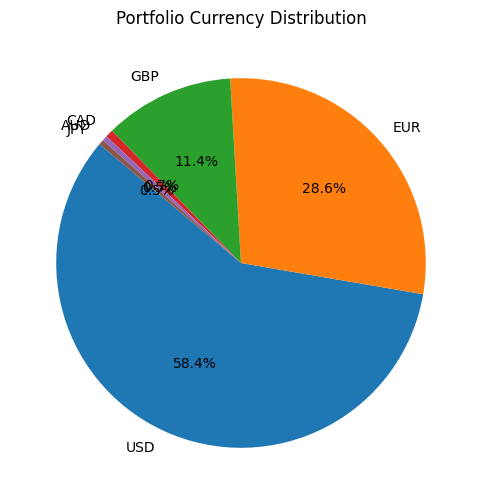

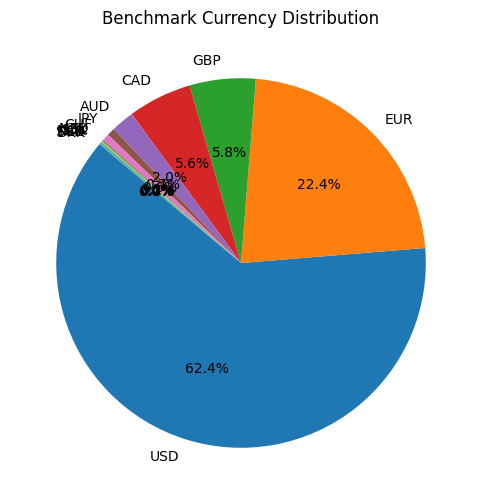

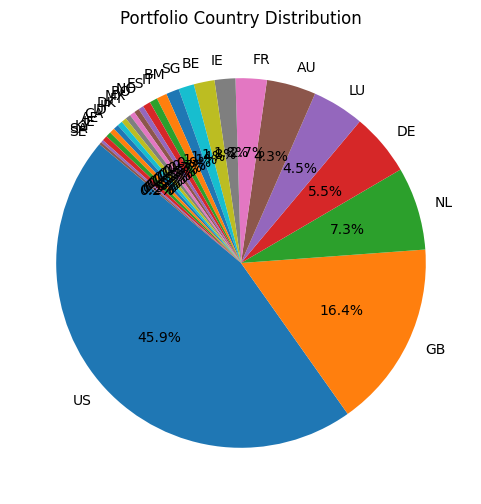

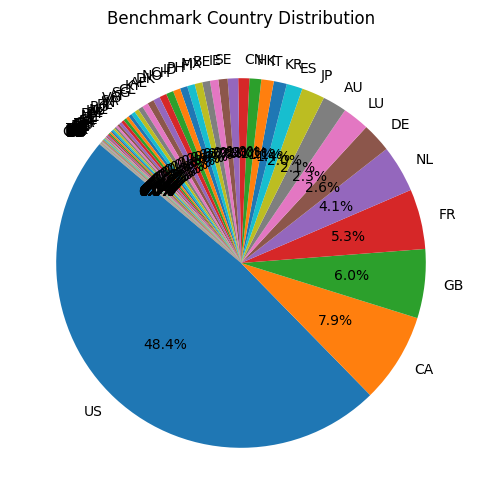

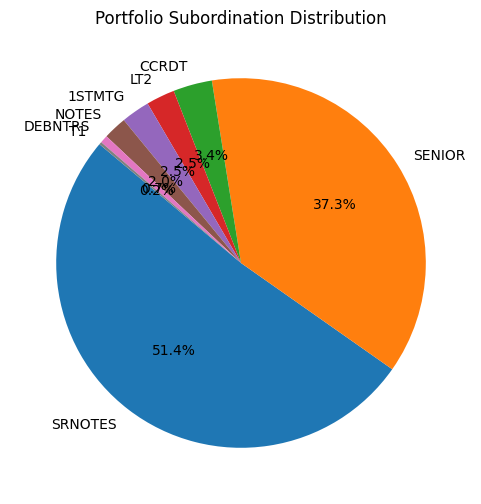

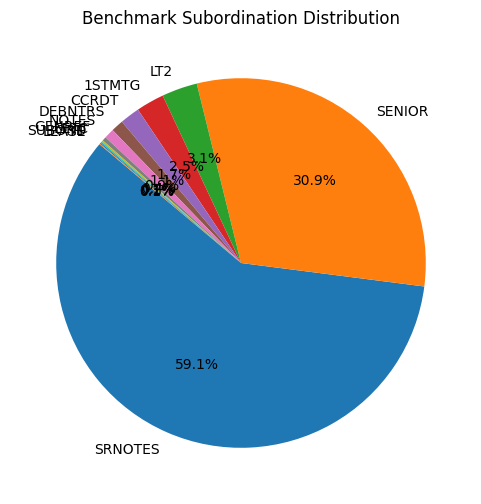

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna().copy(), benchmark_data.dropna().copy()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def count_issuers(data):
    data = data.copy()
    data["Issuer"] = data["Bond_Name"].str.extract(r'([A-Za-z]+)')
    return data["Issuer"].nunique()

def plot_pie_chart(data, column, title):
    counts = data[column].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches.copy()
            matches["Rating_Jump"] = matches["Rating"].apply(lambda x: rating_order.index(clean_rating(portfolio_row["Rating"])) - rating_order.index(clean_rating(x)))
            matches = matches[matches["Rating_Jump"] > 0]

            if not matches.empty:
                best_match = matches.loc[matches["Rating_Jump"].idxmax()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], best_match["Rating_Jump"]
                ])

    return pd.DataFrame(result).sort_values(by="Rating_Jump", ascending=False)

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    print("\nPortfolio vs. Benchmark Analysis:")
    print(f"Total Securities - Portfolio: {len(portfolio_data)}, Benchmark: {len(benchmark_data)}")
    print(f"Total Issuers - Portfolio: {count_issuers(portfolio_data)}, Benchmark: {count_issuers(benchmark_data)}")

    plot_pie_chart(portfolio_data, "Currency", "Portfolio Currency Distribution")
    plot_pie_chart(benchmark_data, "Currency", "Benchmark Currency Distribution")
    plot_pie_chart(portfolio_data, "Country", "Portfolio Country Distribution")
    plot_pie_chart(benchmark_data, "Country", "Benchmark Country Distribution")
    plot_pie_chart(portfolio_data, "Subordination", "Portfolio Subordination Distribution")
    plot_pie_chart(benchmark_data, "Subordination", "Benchmark Subordination Distribution")

if __name__ == "__main__":
    main()


In [25]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving BlueBay IG.xlsx to BlueBay IG (8).xlsx
Uploaded file: BlueBay IG (8).xlsx


ValueError: Length mismatch: Expected axis has 3 elements, new values have 7 elements

In [26]:
import pandas as pd
from google.colab import files

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    result_df = compare_bonds(portfolio_data, benchmark_data)
    filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=100)
    relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=0.5)
    higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

    output_file = "Vision_Output.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
        filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < 100", index=False)
        relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Half Spread", index=False)
        higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

    print(f"Output saved to {output_file}")
    files.download(output_file)

if __name__ == "__main__":
    main()


Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (11).xlsx
Uploaded file: Vision 3.0 (11).xlsx
Output saved to Vision_Output.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import { useState } from "react";
import * as XLSX from "xlsx";

export default function BondAnalysisApp() {
  const [file, setFile] = useState(null);
  const [loading, setLoading] = useState(false);
  const [activeTab, setActiveTab] = useState("allSpreadPickups");
  const [outputData, setOutputData] = useState({
    allSpreadPickups: [],
    filteredSpreadPickups: [],
    relativeSpreadPickups: [],
    higherRating: []
  });

  const handleFileChange = (event) => {
    setFile(event.target.files[0]);
  };

  const processFile = async () => {
    if (!file) {
      alert("Please select a file first!");
      return;
    }
    setLoading(true);

    const reader = new FileReader();
    reader.onload = (event) => {
      const data = new Uint8Array(event.target.result);
      const workbook = XLSX.read(data, { type: "array" });
      const sheetName = workbook.SheetNames[0];
      const sheet = workbook.Sheets[sheetName];
      const jsonData = XLSX.utils.sheet_to_json(sheet, { header: 1 });

      if (jsonData.length < 8) {
        alert("Invalid file format. Please check the input file.");
        setLoading(false);
        return;
      }

      const headers = jsonData[7].map((h) => h.trim());
      const bondData = jsonData.slice(8).map((row) => {
        let bond = {};
        headers.forEach((key, i) => {
          bond[key] = row[i];
        });
        return bond;
      }).filter(bond => Object.keys(bond).length > 0);

      const portfolioData = bondData.map(bond => ({
        Bond_Name: bond[headers[0]],
        Currency: bond[headers[1]],
        Country: bond[headers[2]],
        Sector: bond[headers[3]],
        Rating: bond[headers[4]],
        OAS: bond[headers[5]],
        OAD: bond[headers[6]],
        Subordination: bond[headers[7]]
      }));

      const benchmarkData = portfolioData.slice(Math.floor(portfolioData.length / 2));

      const compareBonds = (portfolioData, benchmarkData, maxSpread = null, relativeSpread = null) => {
        let results = [];
        portfolioData.forEach(portfolioBond => {
          const matches = benchmarkData.filter(benchmarkBond => (
            benchmarkBond.Currency === portfolioBond.Currency &&
            benchmarkBond.Country === portfolioBond.Country &&
            benchmarkBond.Sector === portfolioBond.Sector &&
            benchmarkBond.Rating === portfolioBond.Rating &&
            benchmarkBond.Subordination === portfolioBond.Subordination &&
            benchmarkBond.OAS > portfolioBond.OAS
          ));

          if (matches.length > 0) {
            const bestMatch = matches.reduce((prev, current) => (prev.OAS > current.OAS ? prev : current));
            const spreadPickup = bestMatch.OAS - portfolioBond.OAS;

            if ((maxSpread === null || spreadPickup < maxSpread) &&
                (relativeSpread === null || spreadPickup < relativeSpread * portfolioBond.OAS)) {
              results.push({
                Portfolio_Bond: portfolioBond.Bond_Name,
                Portfolio_OAS: portfolioBond.OAS,
                Benchmark_Bond: bestMatch.Bond_Name,
                Benchmark_OAS: bestMatch.OAS,
                Spread_Pickup: spreadPickup.toFixed(2)
              });
            }
          }
        });
        return results;
      };

      const compareBondsHigherRating = (portfolioData, benchmarkData) => {
        const ratingOrder = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
          "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
          "CC+", "CC", "CC-", "C", "D", "NR"];

        return portfolioData.flatMap(portfolioBond => {
          return benchmarkData.filter(benchmarkBond => (
            benchmarkBond.Currency === portfolioBond.Currency &&
            benchmarkBond.Country === portfolioBond.Country &&
            benchmarkBond.Sector === portfolioBond.Sector &&
            benchmarkBond.Subordination === portfolioBond.Subordination &&
            benchmarkBond.OAS >= 0.9 * portfolioBond.OAS &&
            benchmarkBond.OAS <= 1.1 * portfolioBond.OAS &&
            ratingOrder.indexOf(benchmarkBond.Rating) < ratingOrder.indexOf(portfolioBond.Rating)
          )).map(bestMatch => ({
            Portfolio_Bond: portfolioBond.Bond_Name,
            Portfolio_OAS: portfolioBond.OAS,
            Benchmark_Bond: bestMatch.Bond_Name,
            Benchmark_OAS: bestMatch.OAS
          }));
        });
      };

      setOutputData({
        allSpreadPickups: compareBonds(portfolioData, benchmarkData),
        filteredSpreadPickups: compareBonds(portfolioData, benchmarkData, 100),
        relativeSpreadPickups: compareBonds(portfolioData, benchmarkData, null, 0.5),
        higherRating: compareBondsHigherRating(portfolioData, benchmarkData)
      });
      setLoading(false);
    };
    reader.readAsArrayBuffer(file);
  };

  return (
    <div className="flex h-screen">
      <div className="w-1/4 bg-gray-200 p-4">
        <h2 className="text-lg font-bold mb-2">Navigation</h2>
        <ul>
          <li className="cursor-pointer" onClick={() => setActiveTab("allSpreadPickups")}>All Spread Pickups</li>
          <li className="cursor-pointer" onClick={() => setActiveTab("filteredSpreadPickups")}>Filtered Spread Pickups</li>
          <li className="cursor-pointer" onClick={() => setActiveTab("relativeSpreadPickups")}>Relative Spread Pickups</li>
          <li className="cursor-pointer" onClick={() => setActiveTab("higherRating")}>Higher Rating Comparisons</li>
        </ul>
      </div>
      <div className="w-3/4 p-6">
        <h1 className="text-2xl font-bold mb-4">Fixed Income Analysis</h1>
        <input type="file" onChange={handleFileChange} className="mb-4" />
        <button onClick={processFile} className="px-4 py-2 bg-blue-500 text-white rounded-lg" disabled={loading}>
          {loading ? "Processing..." : "Upload & Analyze"}
        </button>
      </div>
    </div>
  );
}


SyntaxError: invalid syntax (<ipython-input-27-2fc2bb64e1a2>, line 1)

In [28]:
pip install streamlit pandas openpyxl xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 2.8 MB/s eta 0:00:00


In [29]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    # ... (keep your existing function as is)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    # ... (keep your existing function as is)

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            output_file = "Vision_Output.xlsx"
            with pd.ExcelWriter(output_file) as writer:
                result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
                filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < Max", index=False)
                relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Relative", index=False)
                higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

            print(f"Output saved to {output_file}")
            files.download(output_file)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

IndentationError: expected an indented block after function definition on line 30 (<ipython-input-29-846ead932e1b>, line 33)

In [30]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    # ... (keep your existing function as is)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            output_file = "Vision_Output.xlsx"
            with pd.ExcelWriter(output_file) as writer:
                result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
                filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < Max", index=False)
                relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Relative", index=False)
                higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

            print(f"Output saved to {output_file}")
            files.download(output_file)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

IndentationError: expected an indented block after function definition on line 30 (<ipython-input-30-acd64561045f>, line 33)

In [31]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    # ... (keep your existing function as is)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            output_file = "Vision_Output.xlsx"
            with pd.ExcelWriter(output_file) as writer:
                result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
                filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < Max", index=False)
                relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Relative", index=False)
                higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

            print(f"Output saved to {output_file}")
            files.download(output_file)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

IndentationError: expected an indented block after function definition on line 30 (<ipython-input-31-acd64561045f>, line 33)

In [32]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            output_file = "Vision_Output.xlsx"
            with pd.ExcelWriter(output_file) as writer:
                result_df.to_excel(writer, sheet_name="All Spread Pickups", index=False)
                filtered_result_df.to_excel(writer, sheet_name="Spread Pickup < Max", index=False)
                relative_result_df.to_excel(writer, sheet_name="Spread Pickup < Relative", index=False)
                higher_rating_df.to_excel(writer, sheet_name="Similar Spread Higher Rating", index=False)

            print(f"Output saved to {output_file}")
            files.download(output_file)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (12).xlsx
Uploaded file: Vision 3.0 (12).xlsx


In [33]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display, HTML

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    # ... (keep your existing function as is)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    # ... (keep your existing function as is)

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            # Create tabbed interface for results
            all_spread = widgets.Output()
            with all_spread:
                display(HTML(result_df.to_html()))

            filtered_spread = widgets.Output()
            with filtered_spread:
                display(HTML(filtered_result_df.to_html()))

            relative_spread = widgets.Output()
            with relative_spread:
                display(HTML(relative_result_df.to_html()))

            higher_rating = widgets.Output()
            with higher_rating:
                display(HTML(higher_rating_df.to_html()))

            tab = widgets.Tab(children=[all_spread, filtered_spread, relative_spread, higher_rating])
            tab.set_title(0, 'All Spread Pickups')
            tab.set_title(1, 'Spread Pickup < Max')
            tab.set_title(2, 'Spread Pickup < Relative')
            tab.set_title(3, 'Similar Spread Higher Rating')

            display(tab)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

IndentationError: expected an indented block after function definition on line 30 (<ipython-input-33-60afea25c393>, line 33)

In [34]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display, HTML

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            # Create tabbed interface for results
            all_spread = widgets.Output()
            with all_spread:
                display(HTML(result_df.to_html()))

            filtered_spread = widgets.Output()
            with filtered_spread:
                display(HTML(filtered_result_df.to_html()))

            relative_spread = widgets.Output()
            with relative_spread:
                display(HTML(relative_result_df.to_html()))

            higher_rating = widgets.Output()
            with higher_rating:
                display(HTML(higher_rating_df.to_html()))

            tab = widgets.Tab(children=[all_spread, filtered_spread, relative_spread, higher_rating])
            tab.set_title(0, 'All Spread Pickups')
            tab.set_title(1, 'Spread Pickup < Max')
            tab.set_title(2, 'Spread Pickup < Relative')
            tab.set_title(3, 'Similar Spread Higher Rating')

            display(tab)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (13).xlsx
Uploaded file: Vision 3.0 (13).xlsx


In [35]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display, HTML

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    # ... (keep your existing function as is)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    # ... (keep your existing function as is)

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            # CSS to make tables more compact and visible
            css = """
            <style>
            table {
                font-size: 10px;
                width: 100%;
                table-layout: fixed;
            }
            th, td {
                white-space: nowrap;
                overflow: hidden;
                text-overflow: ellipsis;
                max-width: 150px;
            }
            </style>
            """

            # Function to create styled HTML table
            def styled_html(df):
                return css + df.to_html(index=False, max_rows=100)

            # Create tabbed interface for results
            all_spread = widgets.Output()
            with all_spread:
                display(HTML(styled_html(result_df)))

            filtered_spread = widgets.Output()
            with filtered_spread:
                display(HTML(styled_html(filtered_result_df)))

            relative_spread = widgets.Output()
            with relative_spread:
                display(HTML(styled_html(relative_result_df)))

            higher_rating = widgets.Output()
            with higher_rating:
                display(HTML(styled_html(higher_rating_df)))

            tab = widgets.Tab(children=[all_spread, filtered_spread, relative_spread, higher_rating])
            tab.set_title(0, 'All Spread Pickups')
            tab.set_title(1, 'Spread Pickup < Max')
            tab.set_title(2, 'Spread Pickup < Relative')
            tab.set_title(3, 'Similar Spread Higher Rating')

            display(tab)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

IndentationError: expected an indented block after function definition on line 30 (<ipython-input-35-4a96a6bd39e1>, line 33)

In [36]:
import pandas as pd
from google.colab import files, widgets
import ipywidgets as widgets
from IPython.display import display, HTML

def upload_file():
    print("Please upload your Excel file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name

def process_file(file_name):
    data = pd.read_excel(file_name, header=7)  # Read Excel with headers on row 8
    data.columns = data.columns.str.strip()  # Trim whitespace from column names

    bond_name_col = data.iloc[:, 0]  # Bond names
    portfolio_data = data.iloc[:, 1:8].copy()
    benchmark_data = data.iloc[:, 8:15].copy()

    expected_columns = ["Currency", "Country", "Sector", "Rating", "OAS", "OAD", "Subordination"]
    portfolio_data.columns = expected_columns
    benchmark_data.columns = expected_columns

    portfolio_data.insert(0, "Bond_Name", bond_name_col)
    benchmark_data.insert(0, "Bond_Name", bond_name_col)

    return portfolio_data.dropna(), benchmark_data.dropna()

def compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=None, relative_spread_pickup=None):
    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Rating"] == portfolio_row["Rating"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] > portfolio_row["OAS"])
        ]

        if not matches.empty:
            best_match = matches.loc[matches["OAS"].idxmax()]
            spread_pickup = best_match["OAS"] - portfolio_row["OAS"]

            if (max_spread_pickup is None or spread_pickup < max_spread_pickup) and \
               (relative_spread_pickup is None or spread_pickup < relative_spread_pickup * portfolio_row["OAS"]):
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"], spread_pickup
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD", "Spread_Pickup"
    ]).sort_values(by="Spread_Pickup", ascending=False)

def compare_bonds_higher_rating(portfolio_data, benchmark_data):
    rating_order = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-",
                    "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-",
                    "CC+", "CC", "CC-", "C", "D", "NR"]

    def clean_rating(rating):
        return rating.split("/")[0] if isinstance(rating, str) else "NR"

    result = []
    for _, portfolio_row in portfolio_data.iterrows():
        matches = benchmark_data[
            (benchmark_data["Currency"] == portfolio_row["Currency"]) &
            (benchmark_data["Country"] == portfolio_row["Country"]) &
            (benchmark_data["Sector"] == portfolio_row["Sector"]) &
            (benchmark_data["Subordination"] == portfolio_row["Subordination"]) &
            (benchmark_data["OAS"] >= 0.9 * portfolio_row["OAS"]) &
            (benchmark_data["OAS"] <= 1.1 * portfolio_row["OAS"])
        ]

        if not matches.empty:
            matches = matches[matches["Rating"].apply(lambda x: rating_order.index(clean_rating(x)) < rating_order.index(clean_rating(portfolio_row["Rating"])))]
            if not matches.empty:
                best_match = matches.loc[matches["Rating"].idxmin()]
                result.append([
                    portfolio_row["Bond_Name"], portfolio_row["Currency"], portfolio_row["Country"],
                    portfolio_row["Sector"], portfolio_row["Rating"], portfolio_row["Subordination"],
                    portfolio_row["OAS"], portfolio_row["OAD"],
                    best_match["Bond_Name"], best_match["Currency"], best_match["Country"], best_match["Sector"],
                    best_match["Rating"], best_match["Subordination"], best_match["OAS"], best_match["OAD"]
                ])

    return pd.DataFrame(result, columns=[
        "Portfolio_Bond", "Portfolio_Currency", "Portfolio_Country", "Portfolio_Sector", "Portfolio_Rating", "Portfolio_Subordination", "Portfolio_OAS", "Portfolio_OAD",
        "Benchmark_Bond", "Benchmark_Currency", "Benchmark_Country", "Benchmark_Sector", "Benchmark_Rating", "Benchmark_Subordination", "Benchmark_OAS", "Benchmark_OAD"
    ])

def main():
    file_name = upload_file()
    portfolio_data, benchmark_data = process_file(file_name)

    # Create widgets for user input
    max_spread_pickup = widgets.FloatText(value=None, description="Max Spread Pickup:")
    relative_spread_pickup = widgets.FloatText(value=None, description="Relative Spread Pickup:")

    # Button to trigger processing
    process_button = widgets.Button(description="Process Data")

    # Output area for results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            max_val = max_spread_pickup.value if max_spread_pickup.value else None
            rel_val = relative_spread_pickup.value if relative_spread_pickup.value else None

            result_df = compare_bonds(portfolio_data, benchmark_data)
            filtered_result_df = compare_bonds(portfolio_data, benchmark_data, max_spread_pickup=max_val)
            relative_result_df = compare_bonds(portfolio_data, benchmark_data, relative_spread_pickup=rel_val)
            higher_rating_df = compare_bonds_higher_rating(portfolio_data, benchmark_data)

            # CSS to make tables more compact and visible
            css = """
            <style>
            table {
                font-size: 10px;
                width: 100%;
                table-layout: fixed;
            }
            th, td {
                white-space: nowrap;
                overflow: hidden;
                text-overflow: ellipsis;
                max-width: 150px;
            }
            </style>
            """

            # Function to create styled HTML table
            def styled_html(df):
                return css + df.to_html(index=False, max_rows=100)

            # Create tabbed interface for results
            all_spread = widgets.Output()
            with all_spread:
                display(HTML(styled_html(result_df)))

            filtered_spread = widgets.Output()
            with filtered_spread:
                display(HTML(styled_html(filtered_result_df)))

            relative_spread = widgets.Output()
            with relative_spread:
                display(HTML(styled_html(relative_result_df)))

            higher_rating = widgets.Output()
            with higher_rating:
                display(HTML(styled_html(higher_rating_df)))

            tab = widgets.Tab(children=[all_spread, filtered_spread, relative_spread, higher_rating])
            tab.set_title(0, 'All Spread Pickups')
            tab.set_title(1, 'Spread Pickup < Max')
            tab.set_title(2, 'Spread Pickup < Relative')
            tab.set_title(3, 'Similar Spread Higher Rating')

            display(tab)

    # Attach the function to the button
    process_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([max_spread_pickup, relative_spread_pickup, process_button, output]))

if __name__ == "__main__":
    main()

Please upload your Excel file.


Saving Vision 3.0.xlsx to Vision 3.0 (14).xlsx
Uploaded file: Vision 3.0 (14).xlsx
